# Differential abundance analysis

In [1]:
figDir = '~/Hyphosphere/data/3Exp/figures'

work_dir = '~/Hyphosphere/data/3Exp/DESeq'

# phyloseq - full object without tree (includes archaea)
physeq_file = '~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_woTree_experimental_woContam.rds'

In [2]:
library(RColorBrewer)
library(vegan)
library(tidyr)
library(dplyr)
library(reshape2)
library(phyloseq)
library(gridExtra)
library(ggplot2)
library(DESeq2)

Warning message:
“package ‘RColorBrewer’ was built under R version 3.6.1”Warning message:
“package ‘vegan’ was built under R version 3.6.1”Loading required package: permute
Warning message:
“package ‘permute’ was built under R version 3.6.1”Loading required package: lattice
Warning message:
“package ‘lattice’ was built under R version 3.6.1”This is vegan 2.5-5
Registered S3 method overwritten by 'dplyr':
  method               from  
  as.data.frame.tbl_df tibble

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘reshape2’ was built under R version 3.6.1”
Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Warning message:
“package ‘phyloseq’ was built under R version 3.6.1”
Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

In [4]:
theme_pub = function (base_size = 11, base_family = "Arial") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

In [11]:
ps = readRDS(physeq_file) %>% subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    
    subset_samples(., SampleType != "GV") 
    # T0R1 has all NaN for some reason
    #subset_samples(!Sample == "T0R1") #%>%
     # re-normalize after subsetting taxa
    #transform_sample_counts(., function(x) x/sum(x))
sample_data(ps)$Rep = as.factor(sample_data(ps)$Rep)

ps


                                  


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15128 taxa and 384 samples ]
sample_data() Sample Data:       [ 384 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 15128 taxa by 6 taxonomic ranks ]

In [8]:
taxa = tax_table(ps) %>% as.data.frame() %>% mutate(ASV = row.names(.))
head(taxa)

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”

Kingdom,Phylum,Class,Order,Family,Genus,ASV
Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,ASV5
Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,ASV6
Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,ASV8
Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,ASV13
Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,ASV14
Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,ASV15


In [12]:
sample_data(ps)[,'Soil'] %>% unique()

,Soil
1.1BP,Lansing
GVCLHN1-BH,Pendelton
GVFLHN1-BH,Florence
HCBS1,Sand


In [89]:
sample_data(ps)$SoilxFungus = paste(sample_data(ps)$Soil,"-",sample_data(ps)$Fungus, sep = "")
sample_data(ps) %>% head()


,Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul,SoilxFungus
1.1BP,1.1BP,3,1.1,Gv,Lansing,BP,HN,1,14,1,1.067,Lansing-Gv
1.1BS,1.1BS,3,1.1,Gv,Lansing,BS,HN,1,14,1,4.421,Lansing-Gv
1.1CH,1.1CH,3,1.1,Gv,Lansing,CH,HN,1,14,1,0.325,Lansing-Gv
1.1CS,1.1CS,3,1.1,Gv,Lansing,CS,HN,1,14,1,2.116,Lansing-Gv
1.1RH,1.1RH,3,1.1,Gv,Lansing,RH,HN,1,14,1,0.174,Lansing-Gv
1.1RT,1.1RT,3,1.1,Gv,Lansing,RT,HN,1,14,1,1.561,Lansing-Gv


# Experiment 2

In [14]:
tmp = ps %>% subset_samples(Experiment == 2)

## Loop script for sample type contrasts in experiment 2
* Fertilizer treatments grouped together

In [15]:
sample_data(tmp)$SampleType %>% unique

[1] "BH" "BP" "BS" "CH" "CS" "RH" "RS"

In [36]:
library("BiocParallel")
register(MulticoreParam(4))

In [37]:
sample_data(tmp)$DAI %>% unique()

[1] 27

In [50]:
sample_data(tmp) %>% as.data.frame() %>% filter(., Fungus == "RI") %>% .$SampleType  %>% unique()

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

[1] "BH" "BS" "CH" "CS" "RH" "RS"

In [53]:
#sample_data(tmp)$SoilxFungus = paste(sample_data(tmp)$Soil, sample_data(tmp)$Fungus, sep = '-')
df.l2fc = NULL
Grouplist = c('Lansing-Gv', 'Florence-Gv', 'Pendelton-Gv')
ContrastList = list(c("CH","CS"), c("CH", "BS"), c("CH", "BP"), c("RH", "RS"), c("BH","BS"), c("BP", "CS"), c("BP", "BS")) 

    for (i in Grouplist) {
            print(i)
          for (j in ContrastList) { 
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j)
                diag
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local")
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI='27') 
             df.l2fc = rbind(df.l2fc, r)
                     }
          }

i = "Lansing-RI"
RIContrastList = list(c("CH","CS"), c("CH", "BS"), c("RH", "RS"), c("BH","BS"))

    for (j in RIContrastList) { 
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j)
                diag
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local")
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI='27') 
             df.l2fc = rbind(df.l2fc, r)
        }

df.l2fc.Exp2 = df.l2fc
# #cleanup
diagdds = NULL
df.l2fc = NULL
r = NULL

[1] "Lansing-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH_RS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Florence-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH_RS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Pendelton-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH_RS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH_RS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [60]:
taxa %>% head() 

Kingdom,Phylum,Class,Order,Family,Genus,ASV
Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,ASV5
Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,ASV6
Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,ASV8
Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,ASV13
Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,ASV14
Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,ASV15


In [95]:
out = df.l2fc.Exp2  %>% left_join(., taxa, by = c("OTU" = "ASV"))
out$Experiment = 2
head(out)
outfile = file.path(work_dir, 'dfl2fc-Exp2.txt')

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
977.381944,-1.084928,0.6149908,-1.7641368,7.770894e-02,2.376944e-01,ASV5,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,2
772.320938,8.411572,1.4161221,5.9398638,2.852590e-09,7.496606e-08,ASV6,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,2
56.195482,8.815929,1.4665514,6.0113328,1.840042e-09,5.037115e-08,ASV8,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,2
3.676573,1.393277,3.0166225,0.4618665,6.441770e-01,NA,ASV13,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,2
284.185280,5.947743,0.5873419,10.1265441,4.212760e-24,2.767783e-21,ASV14,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,2
49.214540,4.239251,2.4298523,1.7446536,8.104519e-02,2.453764e-01,ASV15,Lansing-Gv,SampleType,CH_CS,27,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,2


In [96]:
write.table(out, file = outfile, row.names = FALSE, sep = '\t')

# Experiment 1

In [90]:
tmp = ps %>% subset_samples(Experiment == 1)

In [91]:
sample_data(tmp)$DAI %>% unique

[1] 81

In [92]:
colnames(sample_data(tmp))

[1] "Sample"              "Experiment"          "Plant"              
 [4] "Fungus"              "Soil"                "SampleType"         
 [7] "Treatment"           "TimePoint"           "DAI"                
[10] "Rep"                 "Concentration_ng.ul" "SoilxFungus"

In [93]:
#sample_data(tmp)$SoilxFungus = paste(sample_data(tmp)$Soil, sample_data(tmp)$Fungus, sep = '-')
df.l2fc = NULL
Grouplist = c('Lansing-Gv')
ContrastList = list(c("CH","CS"), c("CH", "RT"), c("RT", "CS")) 

    for (i in Grouplist) {
            print(i)
          for (j in ContrastList) { 
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j)
                diag
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local")
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI='81') 
             df.l2fc = rbind(df.l2fc, r)
                     }
          }



df.l2fc.Exp1 = df.l2fc
# #cleanup
diagdds = NULL
df.l2fc = NULL
r = NULL

[1] "Lansing-Gv"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH_RT"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RT_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [97]:
out = df.l2fc.Exp1  %>% left_join(., taxa, by = c("OTU" = "ASV"))
out$Experiment = 1
head(out)
outfile = file.path(work_dir, 'dfl2fc-Exp1.txt')

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
331.72029,-2.716497,0.5208573,-5.215434,1.833878e-07,1.512136e-05,ASV5,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,1
136.95264,4.977612,1.1905977,4.180767,2.905274e-05,9.562139e-04,ASV6,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,1
0.00000,NA,NA,NA,NA,NA,ASV8,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,1
0.00000,NA,NA,NA,NA,NA,ASV13,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,1
26.70389,8.430090,1.7889885,4.712210,2.450445e-06,1.236658e-04,ASV14,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,1
0.00000,NA,NA,NA,NA,NA,ASV15,Lansing-Gv,SampleType,CH_CS,81,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,1


In [98]:
write.table(out, file = outfile, row.names = FALSE, sep = '\t')

# Start here Experiment 3

In [99]:
tmp = ps %>% subset_samples(Experiment == 3)

In [100]:
sample_data(tmp)$DAI %>% unique

[1] 14 24 35 45 65

In [102]:
sample_data(tmp)$SampleType %>% unique()

[1] "BP" "BS" "CH" "CS" "RH" "RT"

In [101]:
colnames(sample_data(tmp))

[1] "Sample"              "Experiment"          "Plant"              
 [4] "Fungus"              "Soil"                "SampleType"         
 [7] "Treatment"           "TimePoint"           "DAI"                
[10] "Rep"                 "Concentration_ng.ul" "SoilxFungus"

In [106]:
#sample_data(tmp)$SoilxFungus = paste(sample_data(tmp)$Soil, sample_data(tmp)$Fungus, sep = '-')
df.l2fc = NULL

Grouplist = c('Lansing-Gv')

# Date 65 does not have root hyphae samples, so run in separate loop
DateList = c(14, 24, 35, 45)
# Contrasts for first for sampling dates
ContrastList = list(c("CH","CS"), c("CH", "BS"), c("CH", "BP"), c("RH", "RT"), c("RH","CS"), c("BP", "CS"), c("BP", "BS")) 


    for (i in Grouplist) {
            print(i)
        for (k in DateList) {
                print(k)
          for (j in ContrastList) { 
              print(j)
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j)
                diag
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local")
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI=k) 
             df.l2fc = rbind(df.l2fc, r)
                     }
            }
          }



# Date 65 does not have root hyphae samples, so run in separate loop
DateList = 65
# Contrast list for day 65
ContrastList = list(c("CH","CS"), c("CH", "BS"), c("CH", "BP"), c("BP", "CS"), c("BP", "BS")) 

    for (i in Grouplist) {
            print(i)
        for (k in DateList) {
                print(k)
          for (j in ContrastList) { 
              print(j)
                phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% j)
                diag
                numerator = j[1]
                denom<-j[2]
                print(paste(numerator, denom, sep = "_"))
                #make DESeq object
                diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
                diagdds = DESeq(diagdds, fitType="local")
#               for (k in (j+1):length(GenoList)) { # k = index of 2nd genotype
#                 geno2<-GenoList[k]
#               #  print(paste0(geno1,".",geno2)) # debugging line to make sure all pairwise comparisons are represented
           # get log2 fold change between this pair of genotypes
              r =  results(diagdds,contrast=c('SampleType',numerator,denom),parallel=TRUE) %>% as.data.frame %>% 
                    mutate(OTU=row.names(.),Subset = i, Term='SampleType',Contrast=paste0(numerator,'_',denom),DAI=k) 
             df.l2fc = rbind(df.l2fc, r)
                     }
            }
          }

df.l2fc.Exp3 = df.l2fc
# #cleanup
diagdds = NULL
df.l2fc = NULL
r = NULL

[1] "Lansing-Gv"
[1] 14
[1] "CH" "CS"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BS"
[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BP"
[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH" "RT"
[1] "RH_RT"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH" "CS"
[1] "RH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "CS"
[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "BS"
[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] 24
[1] "CH" "CS"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BS"
[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BP"
[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH" "RT"
[1] "RH_RT"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH" "CS"
[1] "RH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "CS"
[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "BS"
[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] 35
[1] "CH" "CS"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BS"
[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BP"
[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH" "RT"
[1] "RH_RT"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH" "CS"
[1] "RH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "CS"
[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "BS"
[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] 45
[1] "CH" "CS"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BS"
[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BP"
[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH" "RT"
[1] "RH_RT"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "RH" "CS"
[1] "RH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "CS"
[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "BS"
[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Lansing-Gv"
[1] 65
[1] "CH" "CS"
[1] "CH_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BS"
[1] "CH_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "CH" "BP"
[1] "CH_BP"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "CS"
[1] "BP_CS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "BP" "BS"
[1] "BP_BS"


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [109]:
out = df.l2fc.Exp3  %>% left_join(., taxa, by = c("OTU" = "ASV"))
out$Experiment = 3
head(out)
outfile = file.path(work_dir, 'dfl2fc-Exp3.txt')

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
176.907064,-0.5828995,0.1583464,-3.681167,2.321693e-04,1.806110e-03,ASV5,Lansing-Gv,SampleType,CH_CS,14,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,3
29.502932,2.1048765,0.7326738,2.872870,4.067615e-03,1.834144e-02,ASV6,Lansing-Gv,SampleType,CH_CS,14,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,3
32.537078,2.7113831,0.8328413,3.255582,1.131602e-03,6.514257e-03,ASV8,Lansing-Gv,SampleType,CH_CS,14,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,3
1.706995,3.2740030,2.9244316,1.119535,NA,NA,ASV13,Lansing-Gv,SampleType,CH_CS,14,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,3
529.888433,6.1264757,0.4434443,13.815662,2.050615e-43,5.902354e-41,ASV14,Lansing-Gv,SampleType,CH_CS,14,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,3
40.753724,4.6711786,1.3639826,3.424662,6.155658e-04,4.022736e-03,ASV15,Lansing-Gv,SampleType,CH_CS,14,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,3


In [110]:
write.table(out, file = outfile, row.names = FALSE, sep = '\t')

# Write all tables

In [118]:
df.l2fc.Exp1$Experiment = 1
rm(t1)
head(df.l2fc.Exp1)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Experiment
331.72029,-2.716497,0.5208573,-5.215434,1.833878e-07,1.512136e-05,ASV5,Lansing-Gv,SampleType,CH_CS,81,1
136.95264,4.977612,1.1905977,4.180767,2.905274e-05,9.562139e-04,ASV6,Lansing-Gv,SampleType,CH_CS,81,1
0.00000,NA,NA,NA,NA,NA,ASV8,Lansing-Gv,SampleType,CH_CS,81,1
0.00000,NA,NA,NA,NA,NA,ASV13,Lansing-Gv,SampleType,CH_CS,81,1
26.70389,8.430090,1.7889885,4.712210,2.450445e-06,1.236658e-04,ASV14,Lansing-Gv,SampleType,CH_CS,81,1
0.00000,NA,NA,NA,NA,NA,ASV15,Lansing-Gv,SampleType,CH_CS,81,1


In [114]:
df.l2fc.Exp2$Experiment = 2
head(df.l2fc.Exp2)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Experiment
977.381944,-1.084928,0.6149908,-1.7641368,7.770894e-02,2.376944e-01,ASV5,Lansing-Gv,SampleType,CH_CS,27,2
772.320938,8.411572,1.4161221,5.9398638,2.852590e-09,7.496606e-08,ASV6,Lansing-Gv,SampleType,CH_CS,27,2
56.195482,8.815929,1.4665514,6.0113328,1.840042e-09,5.037115e-08,ASV8,Lansing-Gv,SampleType,CH_CS,27,2
3.676573,1.393277,3.0166225,0.4618665,6.441770e-01,NA,ASV13,Lansing-Gv,SampleType,CH_CS,27,2
284.185280,5.947743,0.5873419,10.1265441,4.212760e-24,2.767783e-21,ASV14,Lansing-Gv,SampleType,CH_CS,27,2
49.214540,4.239251,2.4298523,1.7446536,8.104519e-02,2.453764e-01,ASV15,Lansing-Gv,SampleType,CH_CS,27,2


In [116]:
df.l2fc.Exp3$Experiment = 3
head(df.l2fc.Exp3)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,Term,Contrast,DAI,Experiment
176.907064,-0.5828995,0.1583464,-3.681167,2.321693e-04,1.806110e-03,ASV5,Lansing-Gv,SampleType,CH_CS,14,3
29.502932,2.1048765,0.7326738,2.872870,4.067615e-03,1.834144e-02,ASV6,Lansing-Gv,SampleType,CH_CS,14,3
32.537078,2.7113831,0.8328413,3.255582,1.131602e-03,6.514257e-03,ASV8,Lansing-Gv,SampleType,CH_CS,14,3
1.706995,3.2740030,2.9244316,1.119535,NA,NA,ASV13,Lansing-Gv,SampleType,CH_CS,14,3
529.888433,6.1264757,0.4434443,13.815662,2.050615e-43,5.902354e-41,ASV14,Lansing-Gv,SampleType,CH_CS,14,3
40.753724,4.6711786,1.3639826,3.424662,6.155658e-04,4.022736e-03,ASV15,Lansing-Gv,SampleType,CH_CS,14,3


In [ ]:
t1 = df.l2fc.Exp1
colnames(t1)

# Sandbox

## Differential abundance Core Hyphae to Bulk Soil

[1] "Lansing-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Lansing-RI"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Florence-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


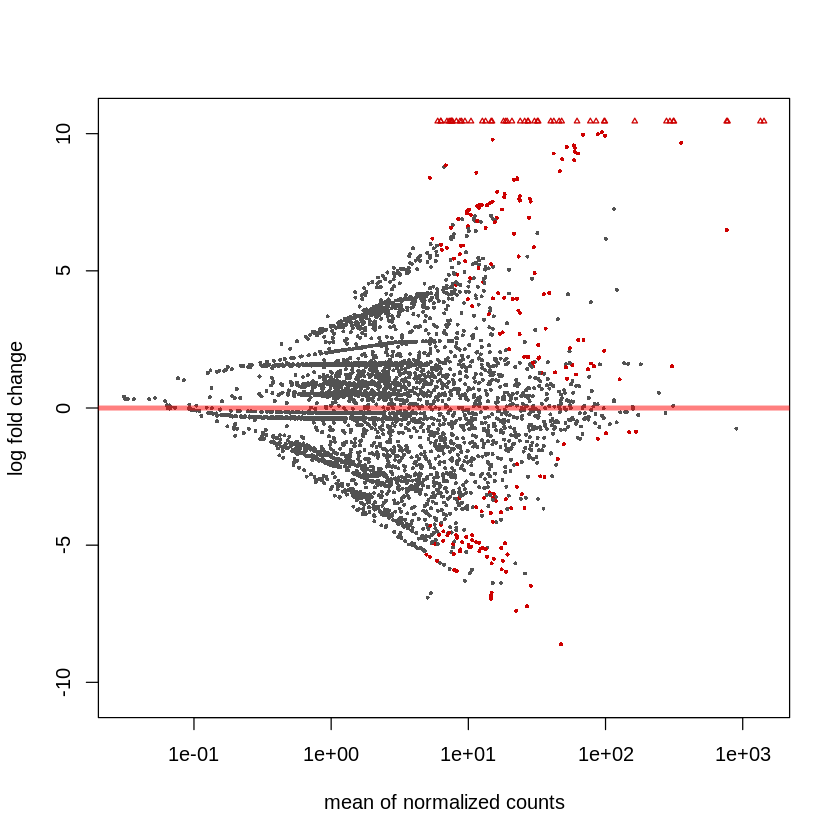

[1] "Pendelton-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


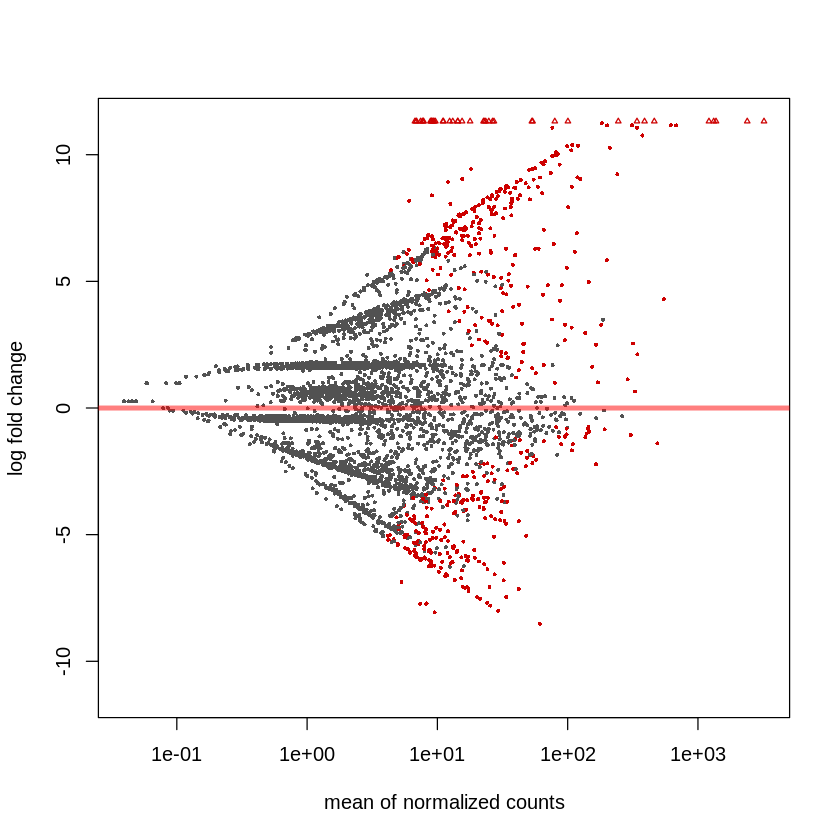

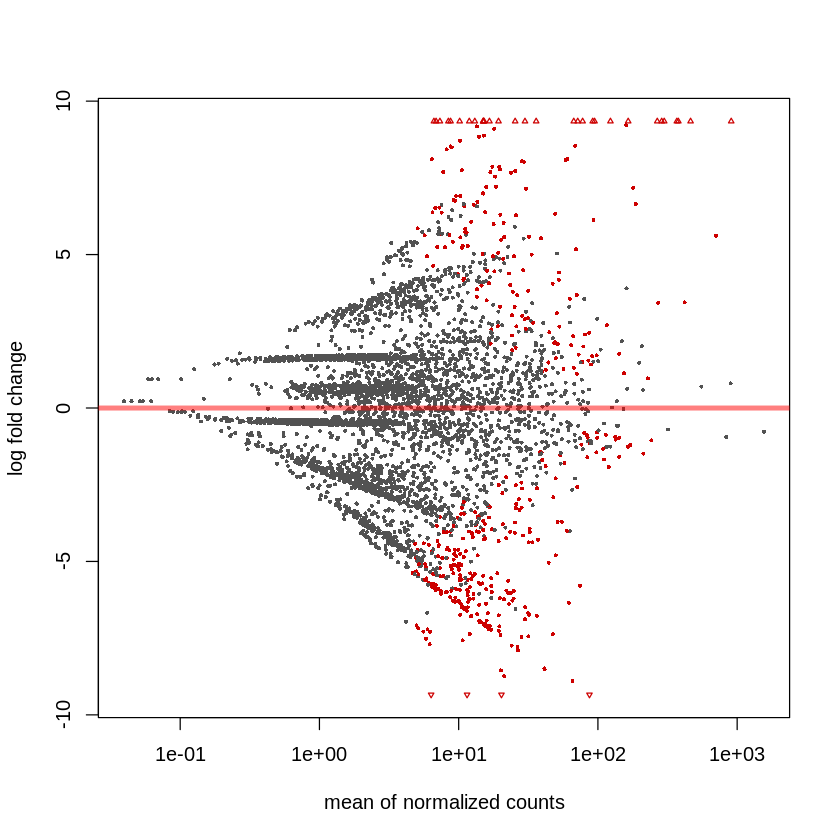

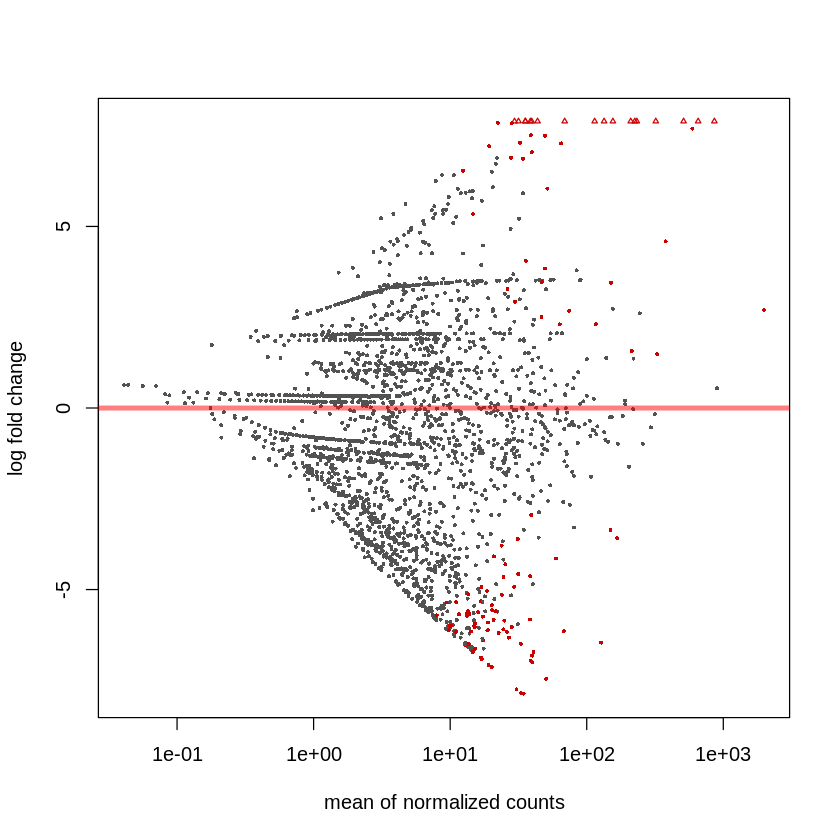

In [28]:
# Loop script for specific contrasts
df.l2fc = NULL



#create DESeq dataset and DESeq object
Grouplist = c('Lansing-Gv', 'Lansing-RI', 'Florence-Gv', 'Pendelton-Gv')
#set up list to store results output
#myresults = paste(FungusList, ".res", sep = "") %>% as.list()


    for (i in Grouplist) {

        print(i)
        phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% c("BS", "CH"))

        diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
        diagdds = DESeq(diagdds, fitType="local")
        # get log2 fold change between this pair of genotypes
        res =  results(diagdds,contrast=c('SampleType',"CH","BS"), lfcThreshold = 0)

        r =   res %>% as.data.frame %>%
               mutate(ASV=row.names(.),Test='CH-BS', contrast = "CHBS", group = i, Experiment = '2')
        #Store results for each fungus in list, e.g. myresults$Gv
        #myresults[FungusList[i]] = res
        plotMA(res)
        df.l2fc = rbind(df.l2fc, r)
    }
    

df.l2fc.2.CHBS = df.l2fc

In [29]:
sample_data(tmp)$SampleType %>% unique

[1] BH BS BP CS CH RH RS
Levels: BH BP BS CH CS RH RS

## Differential abundance Core Hyphae to Bulk POM
* Note that BPOM was not collected from RI cores.  Will have to rely on Gv comparison and BP vs BH to highlight taxa that are a result of BPOM enrichment

[1] "Lansing-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Florence-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Pendelton-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


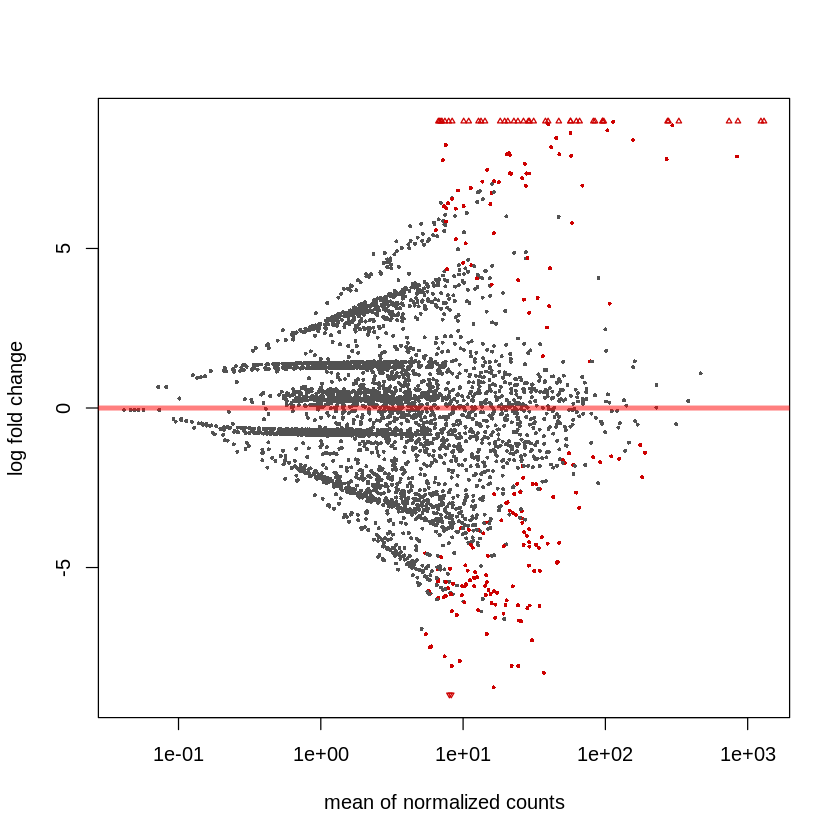

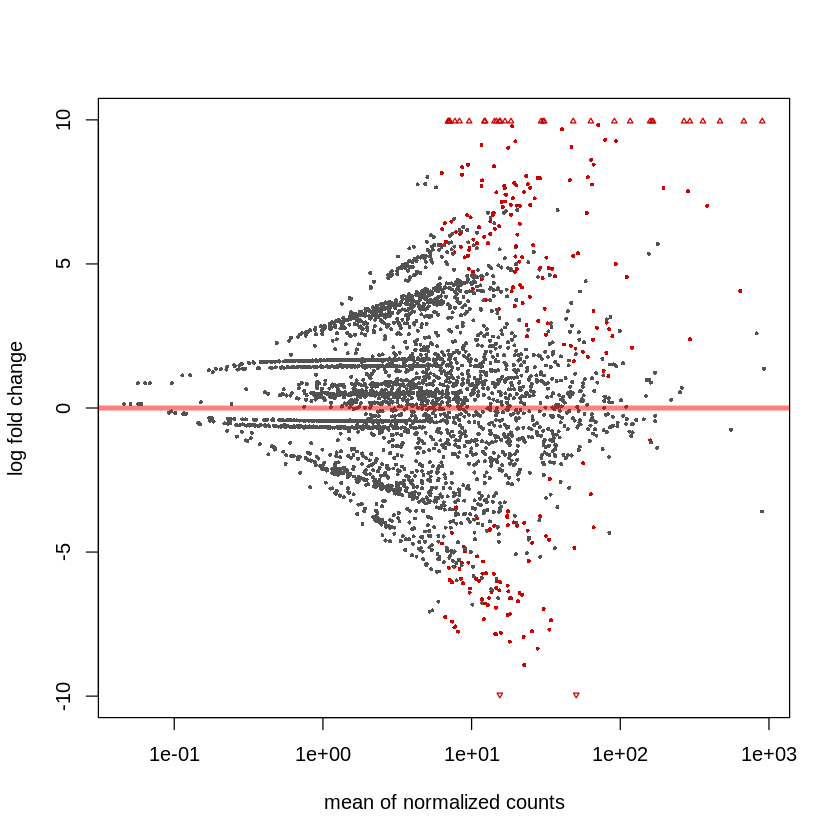

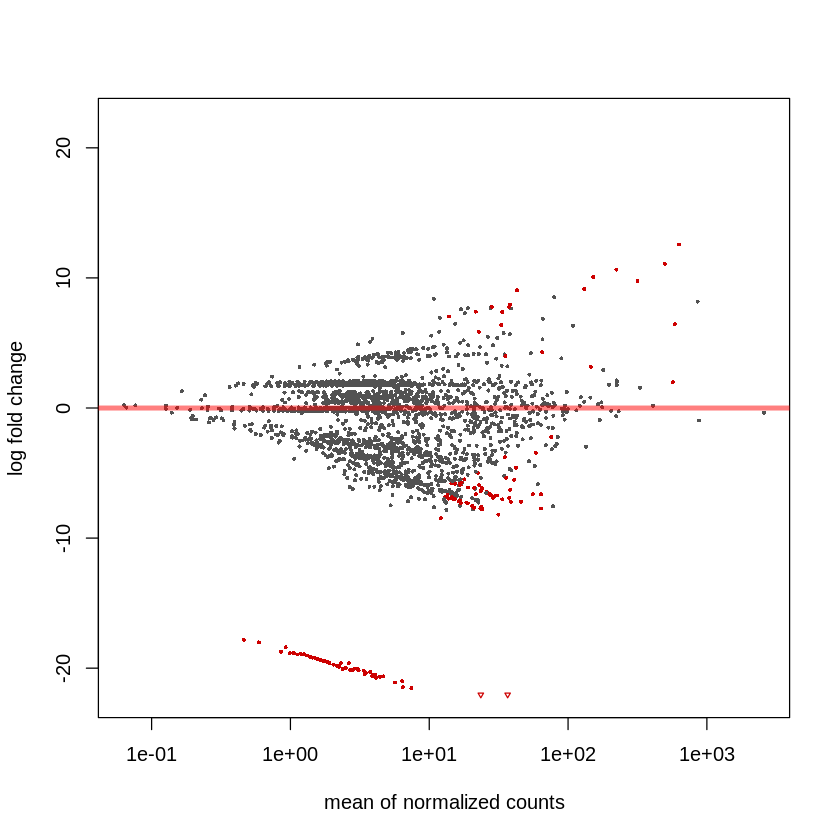

In [35]:
# Loop script for specific contrasts
df.l2fc = NULL



#create DESeq dataset and DESeq object
Grouplist = c('Lansing-Gv', 'Florence-Gv', 'Pendelton-Gv')
#set up list to store results output
#myresults = paste(FungusList, ".res", sep = "") %>% as.list()


    for (i in Grouplist) {

        print(i)
        phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% c("BP", "CH"))

        diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
        diagdds = DESeq(diagdds, fitType="local")
        # get log2 fold change between this pair of genotypes
        res =  results(diagdds,contrast=c('SampleType',"CH","BP"), lfcThreshold = 0)

        r =   res %>% as.data.frame %>%
               mutate(ASV=row.names(.),Test='CH-BP', contrast = "CHBP", group = i, Experiment = '2')
        #Store results for each fungus in list, e.g. myresults$Gv
        #myresults[FungusList[i]] = res
        plotMA(res)
        df.l2fc = rbind(df.l2fc, r)
    }
    

df.l2fc.2.CHBP = df.l2fc

## Differential abundance Root hyphae to root slurry
* need to rerun

[1] "Lansing-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Lansing-RI"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Florence-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


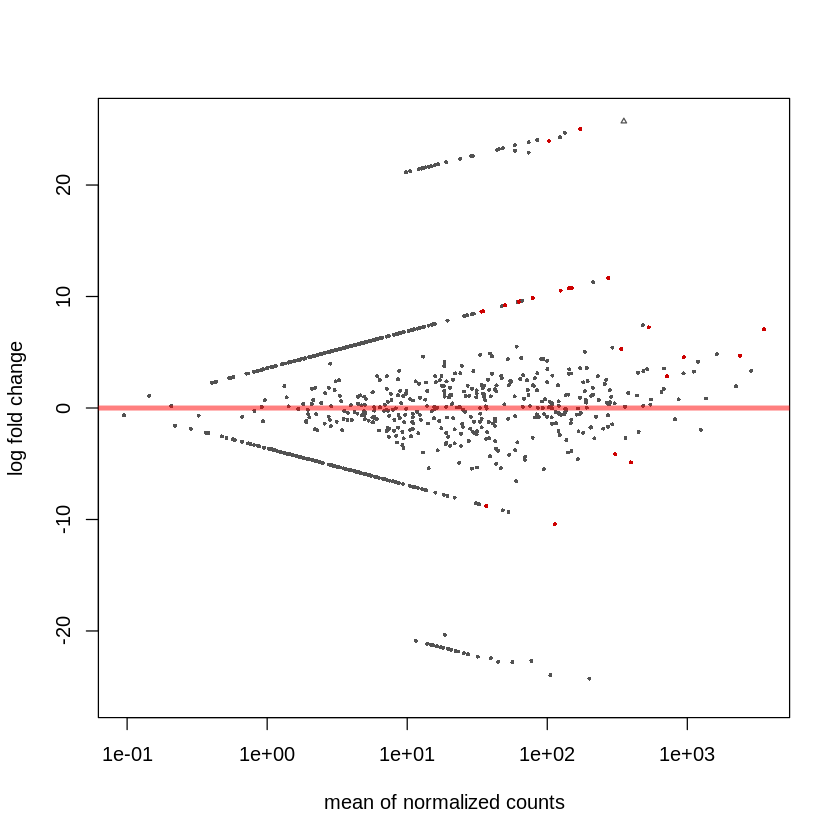

[1] "Pendelton-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


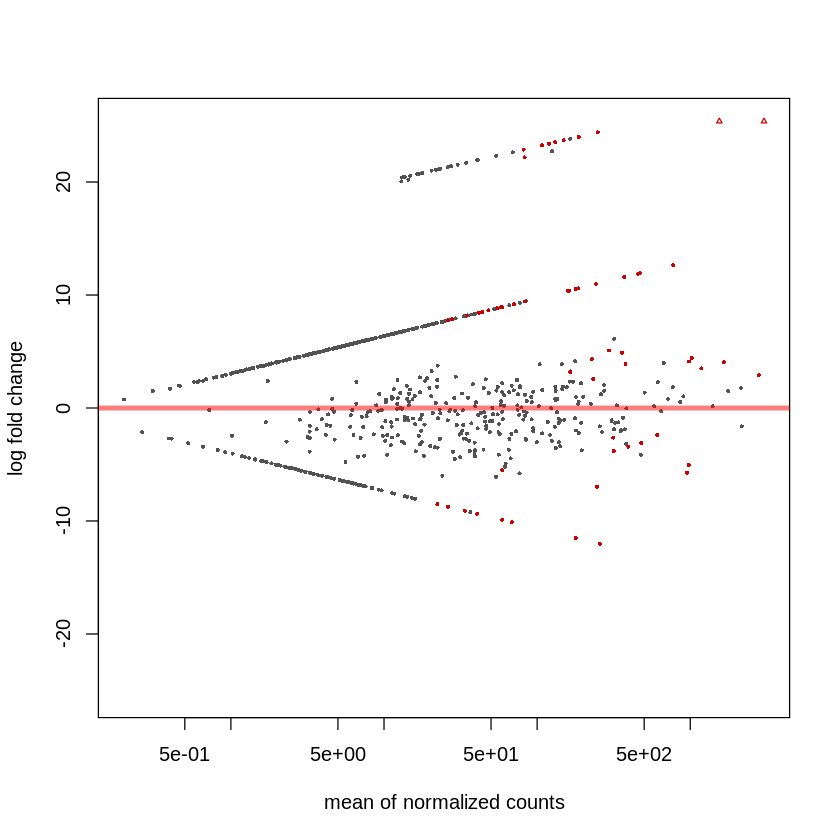

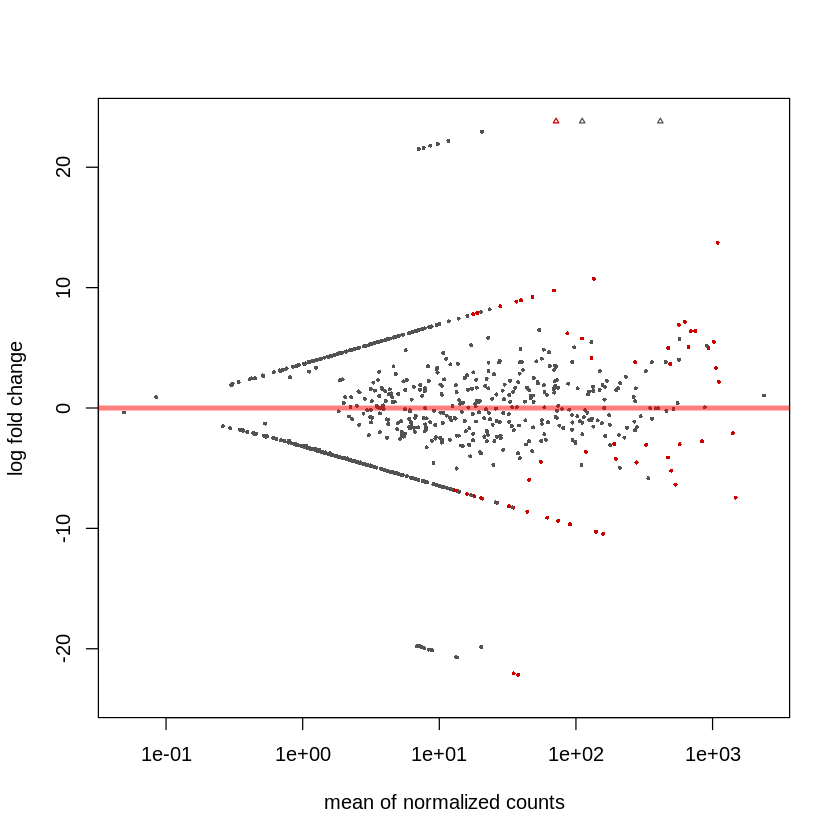

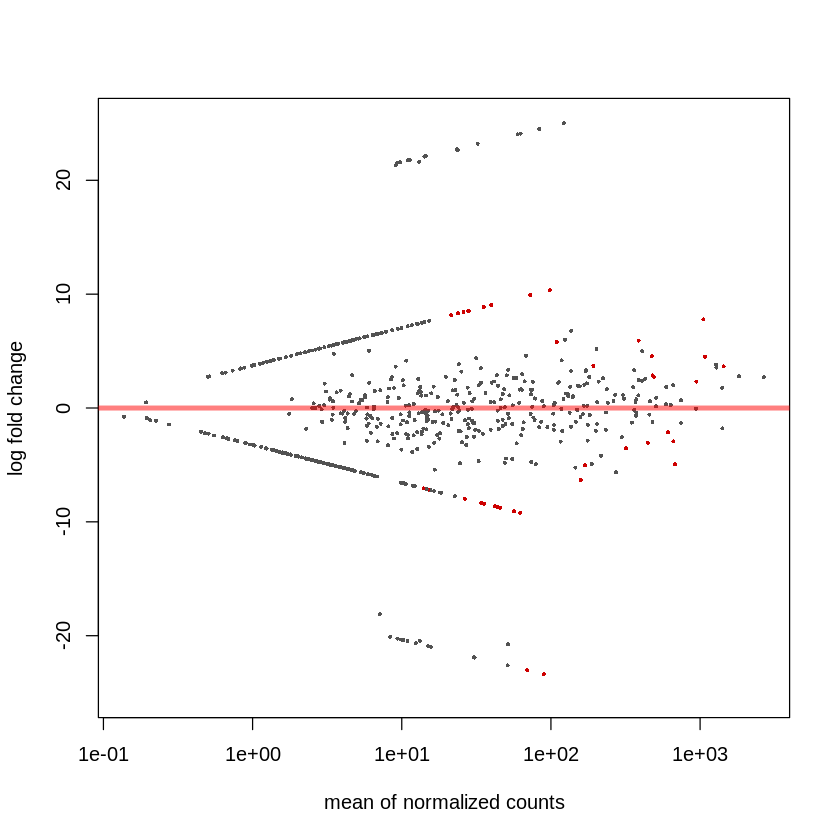

In [37]:
# Loop script for specific contrasts
df.l2fc = NULL



#create DESeq dataset and DESeq object
Grouplist = c('Lansing-Gv', 'Lansing-RI', 'Florence-Gv', 'Pendelton-Gv')
#set up list to store results output
#myresults = paste(FungusList, ".res", sep = "") %>% as.list()


    for (i in Grouplist) {

        print(i)
        phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% c("RS", "RH"))

        diagdds = phyloseq_to_deseq2(phy, ~ SampleType)
        diagdds = DESeq(diagdds, fitType="local")
        # get log2 fold change between this pair of genotypes
        res =  results(diagdds,contrast=c('SampleType',"RH","RS"), lfcThreshold = 0)

        r =   res %>% as.data.frame %>%
               mutate(ASV=row.names(.),Test='RH-RS', contrast = "RHRS", group = i, Experiment = '2')
        #Store results for each fungus in list, e.g. myresults$Gv
        #myresults[FungusList[i]] = res
        plotMA(res)
        df.l2fc = rbind(df.l2fc, r)
    }
    

df.l2fc.2.RHRS = df.l2fc

## Differential abundance Bulk hyphae to bulk soil

[1] "Lansing-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Lansing-RI"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Florence-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


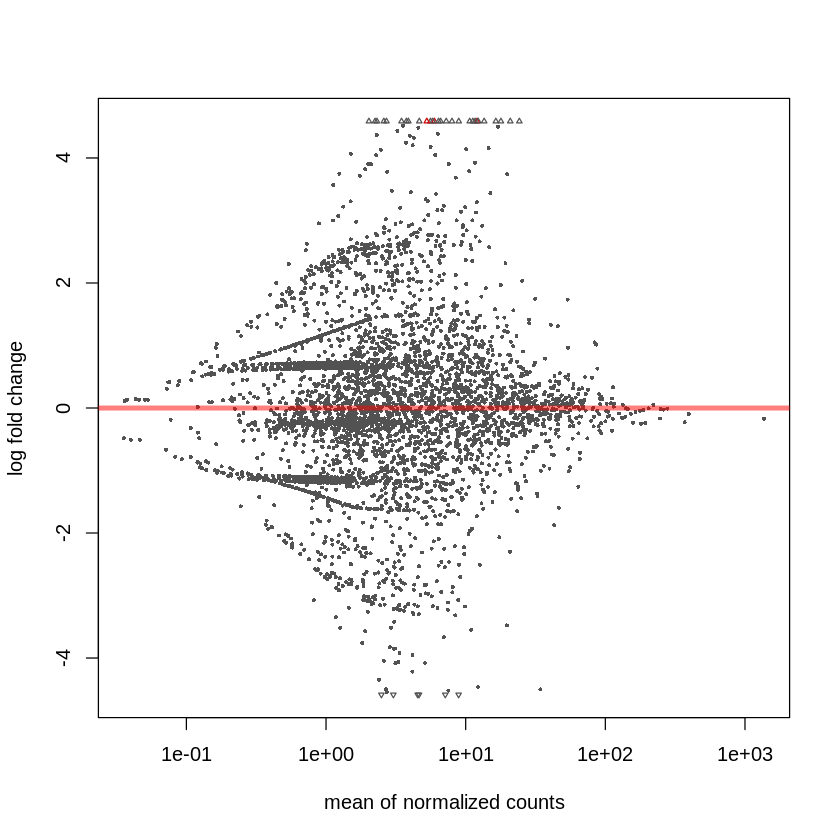

[1] "Pendelton-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


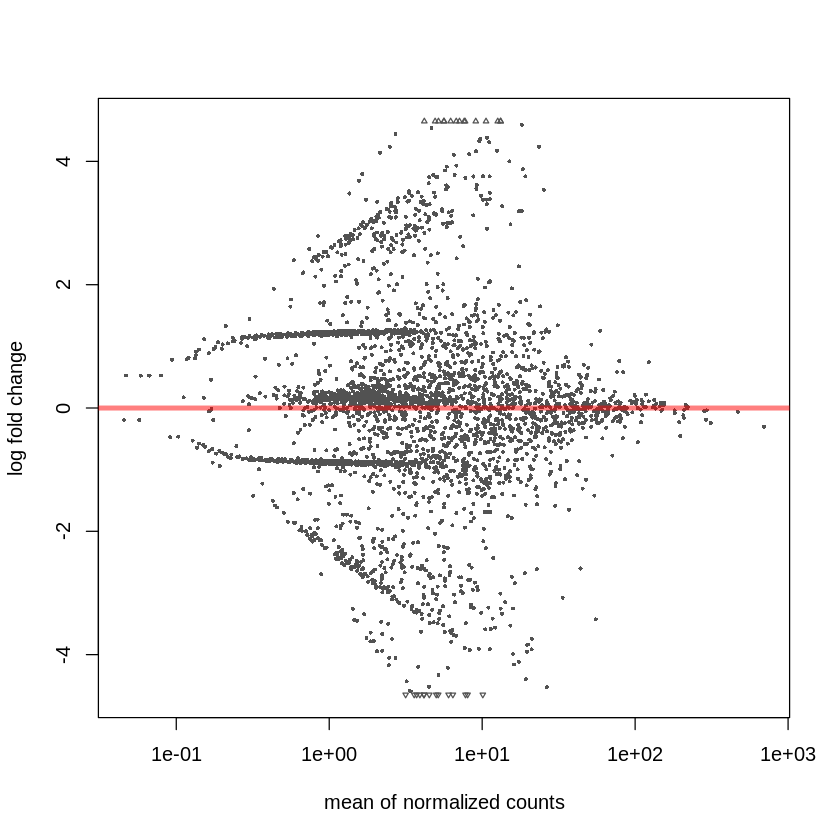

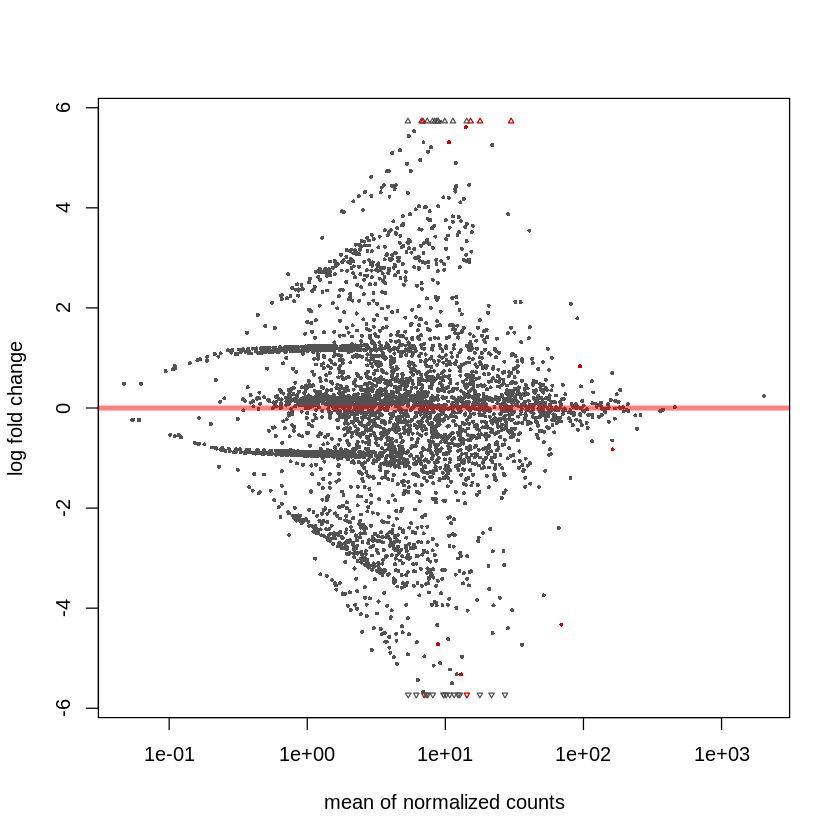

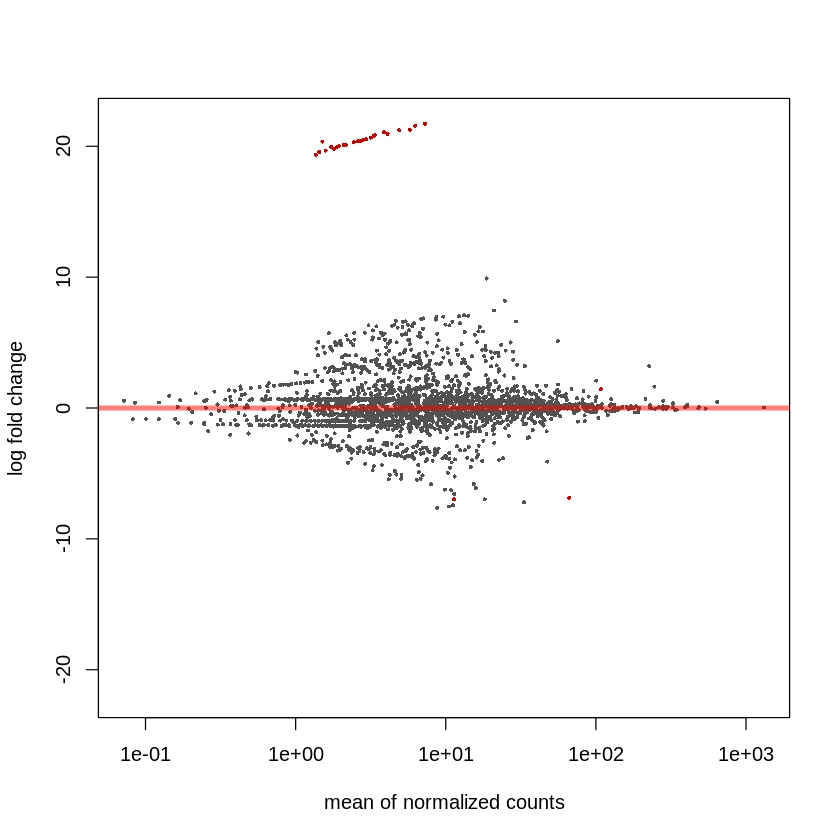

In [38]:
# Loop script for specific contrasts
df.l2fc = NULL



#create DESeq dataset and DESeq object
Grouplist = c('Lansing-Gv', 'Lansing-RI', 'Florence-Gv', 'Pendelton-Gv')
#set up list to store results output
#myresults = paste(FungusList, ".res", sep = "") %>% as.list()


    for (i in Grouplist) {

        print(i)
        phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% c("BS", "BH"))

        diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
        diagdds = DESeq(diagdds, fitType="local")
        # get log2 fold change between this pair of genotypes
        res =  results(diagdds,contrast=c('SampleType',"BH","BS"), lfcThreshold = 0)

        r =   res %>% as.data.frame %>%
               mutate(ASV=row.names(.),Test='BH-BS', contrast = "BHBS", group = i, Experiment = '2')
        #Store results for each fungus in list, e.g. myresults$Gv
        #myresults[FungusList[i]] = res
        plotMA(res)
        df.l2fc = rbind(df.l2fc, r)
    }
    

df.l2fc.2.BHBS = df.l2fc

## Differential abundance Bulk pom to core slurry

In [ ]:
# Loop script for specific contrasts
df.l2fc = NULL



#create DESeq dataset and DESeq object
Grouplist = c('Lansing-Gv', 'Florence-Gv', 'Pendelton-Gv')
#set up list to store results output
#myresults = paste(FungusList, ".res", sep = "") %>% as.list()


    for (i in Grouplist) {

        print(i)
        phy = subset_samples(tmp, SoilxFungus == i & SampleType %in% c("BP", "CS"))

        diagdds = phyloseq_to_deseq2(phy, ~ Rep + SampleType)
        diagdds = DESeq(diagdds, fitType="local")
        # get log2 fold change between this pair of genotypes
        res =  results(diagdds,contrast=c('SampleType',"BP","CS"), lfcThreshold = 0)

        r =   res %>% as.data.frame %>%
               mutate(ASV=row.names(.),Test='BP-CS', contrast = "BPCS", group = i, Experiment = '2')
        #Store results for each fungus in list, e.g. myresults$Gv
        #myresults[FungusList[i]] = res
        plotMA(res)
        df.l2fc = rbind(df.l2fc, r)
    }
    

df.l2fc.2.BPCS = df.l2fc

[1] "Lansing-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Florence-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Pendelton-Gv"


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [19]:
head(df.l2fc.2.CHCS)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ASV,Test,contrast,group,Experiment
977.381944,-0.8652458,0.7324997,-1.181223,2.375140e-01,5.205167e-01,ASV5,CH-CS,CHCS,Lansing-Gv,2
772.320938,8.0810377,1.7161087,4.708931,2.490193e-06,4.911578e-05,ASV6,CH-CS,CHCS,Lansing-Gv,2
56.195482,8.9223151,1.3352936,6.681913,2.358435e-11,5.992024e-10,ASV8,CH-CS,CHCS,Lansing-Gv,2
3.676573,5.2489329,2.9829546,1.759642,7.846849e-02,NA,ASV13,CH-CS,CHCS,Lansing-Gv,2
284.185280,5.6984277,0.6641982,8.579409,9.536198e-18,5.717905e-16,ASV14,CH-CS,CHCS,Lansing-Gv,2
49.214540,4.0319781,2.1672561,1.860407,6.282799e-02,2.148892e-01,ASV15,CH-CS,CHCS,Lansing-Gv,2


In [ ]:
# tmp = left_join(df.l2fc.CHCS,taxa, by = "ASV")
# sigtab = tmp %>% filter(padj < 0.05 & log2FoldChange > 2) #& Order %in% 
#                      #   c("Myxococcales", "Betaproteobacteriales", "Rhizobiales", "Sphingomonadales", 
#                      #    "Fibrobacterales", "Cytophagales")) %>% mutate(Order = droplevels(Order))

# x = tapply(sigtab$log2FoldChange, sigtab$Order, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Order = factor(as.character(sigtab$Order), levels=names(x))
# # x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# # x = sort(x, TRUE)
# # sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
# #cs = brewer.pal(12,"Set3")    
# p2 = ggplot(sigtab, aes(x=log2FoldChange, y=ASV, size = baseMean)) + 
#     geom_point(aes(color = Class))+
#   theme_pub(base_size = 12) +
#   #scale_color_manual(values = cs) +
#   theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
#   facet_wrap(~group, ncol = 2)+
#     ggtitle("Enriched in hyphosphere compared to bulk soil")  +
#    theme(legend.position="right")# +
#         #guides(color=guide_legend(ncol=3)) 
# #x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
# #x = sort(x, TRUE)
# #x
#     p2

Warning message in prune_taxa(taxa, phy_tree(x)):
“prune_taxa attempted to reduce tree to 1 or fewer tips.
 tree replaced with NULL.”Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

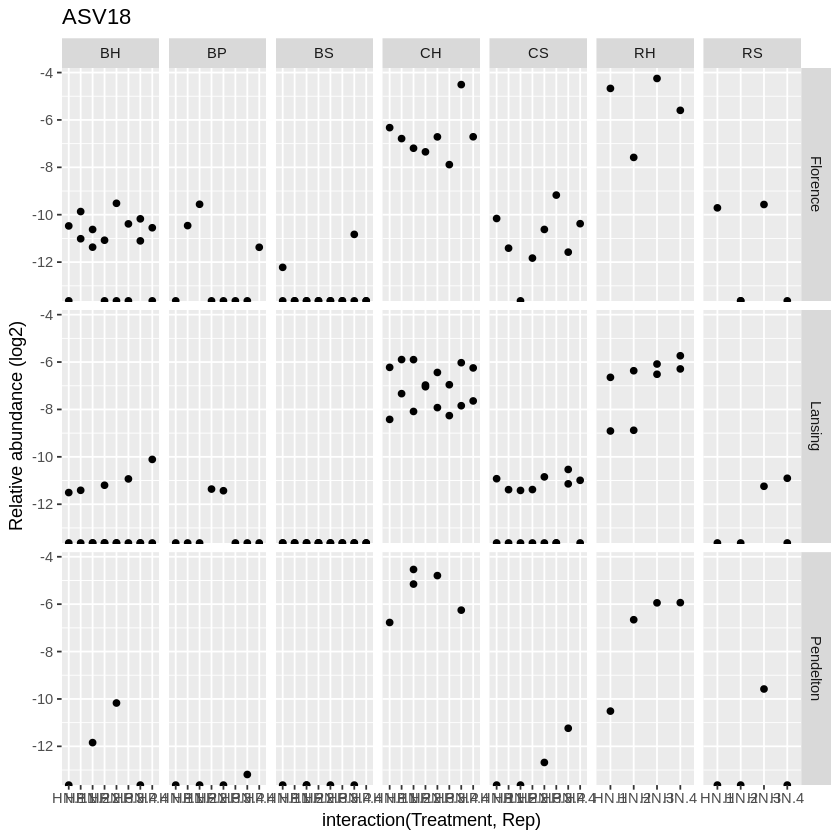

In [217]:
## If using this cell, need to normalize first
# ps.m = prune_taxa("ASV18", ps.snorm)  %>% psmelt()

# plot2 = filter(ps.m, !SampleType %in% c("EB", "PB", "MK") & Soil %in% c("Lansing", "Pendelton", "Florence")) %>%
#     ggplot(., aes(x=interaction(Treatment,Rep), y= log2(Abundance))) +
#     geom_point()+
#     facet_grid(Soil~SampleType, scales = 'free_x')+
#     ggtitle(as.character("ASV18"))+
#     ylab('Relative abundance (log2)')
# plot2

# Check against abundance of MREs in BH samples

In [347]:
ps.Full = readRDS("~/Hyphosphere/Exp11/Exp11_phyloseq.rds")
#ps = subset_taxa(ps, !is.na("Phylum"))

#tax_table(ps) %>% head()

ps.Full = subset_taxa(ps.Full, Kingdom == "Bacteria")
#ps.Full = subset_samples(ps.Full, SampleType %in% c("BS","BH") & Fungus == "Gv") #remove non-experimental controls

In [348]:
ps.MRE = ps.Full %>% transform_sample_counts(., function(x) x/sum(x)) %>% prune_taxa(c("ASV2", "ASV4", "ASV11"),.)
tax_table(ps.MRE)

,Kingdom,Phylum,Class,Order,Family,Genus
ASV4,Bacteria,NA,NA,NA,NA,NA
ASV11,Bacteria,NA,NA,NA,NA,NA
ASV2,Bacteria,NA,NA,NA,NA,NA


Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

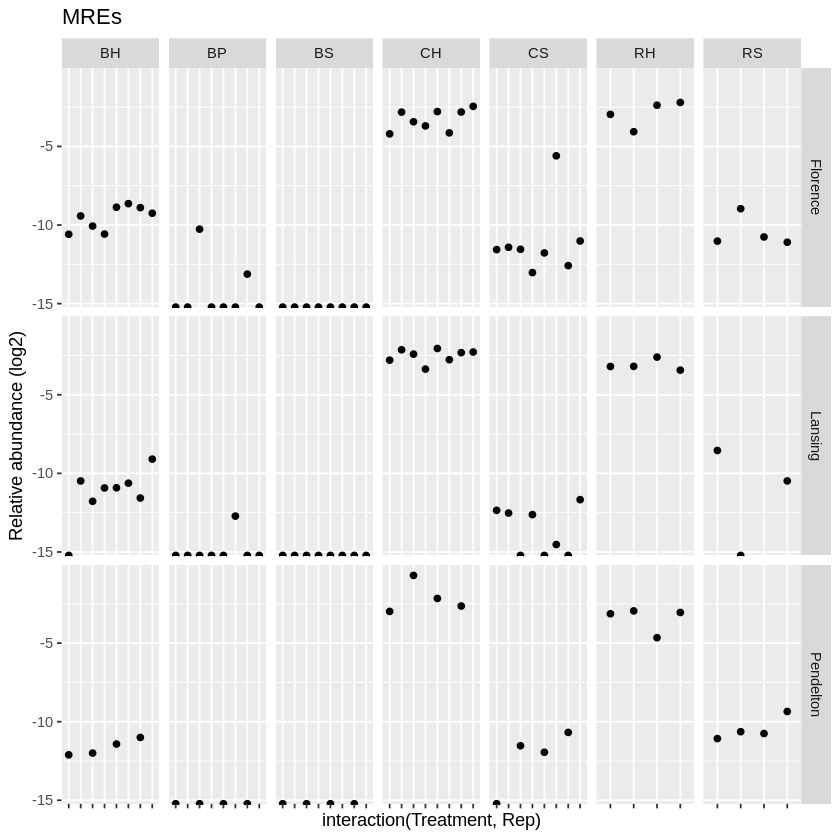

In [354]:
ps.Full %>% transform_sample_counts(., function(x) x/sum(x)) %>% prune_taxa(c("ASV2", "ASV4", "ASV11"),.) %>% 
    psmelt() %>% 
    filter(!SampleType %in% c("EB", "PB", "MK") & Soil %in% c("Lansing", "Pendelton", "Florence") & Fungus == "Gv")  %>%                                     
    group_by(sample_Sample, Soil, SampleType, Treatment, Rep) %>%
    summarise(sAbund = sum(Abundance)) %>%
    ggplot(., aes(x=interaction(Treatment,Rep), y= log2(sAbund))) +
    geom_point()+
    facet_grid(Soil~SampleType, scales = 'free_x')+
    ggtitle(as.character("MREs"))+
    theme(axis.text.x = element_blank())+
    ylab('Relative abundance (log2)')


In [306]:
MREtab = ps.MRE %>% 
    psmelt() %>% 
    group_by(sample_Sample, Soil) %>%
    summarise(sAbund = sum(Abundance))

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

In [307]:
head(MREtab)

sample_Sample,Soil,sAbund
GVCLHN1-BH,Pendelton,0.0002264177
GVCLHN1-BS,Pendelton,0.0000000000
GVCLHN2-BH,Pendelton,0.0002446450
GVCLHN2-BS,Pendelton,0.0000000000
GVCLHN3-BH,Pendelton,0.0003644315
GVCLHN3-BS,Pendelton,0.0000000000


In [355]:
ps.tax = ps %>% 
transform_sample_counts(., function(x) x/sum(x)) %>% 
                        prune_taxa(c("ASV14", "ASV18"),.)
                        #prune_taxa(c("ASV17"),.)
tax_table(ps.tax)

,Kingdom,Phylum,Class,Order,Family,Genus
ASV14,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA
ASV18,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA


In [376]:
ps.tax %>% subset_samples(., SampleType == "CH" & Soil == "Lansing") %>% sample_sums()
                    

171_GVN7HN3-CH 173_GVN7HN4-CH 176_GVN7HP3-CH 177_GVN7HP4-CH 178_RIN7HN3-CH 
   0.030722252    0.023788523    0.020436215    0.019804144    0.008219178 
181_RIN7HN4-CH 184_RIN7HP3-CH 185_RIN7HP4-CH  75_GVN7HN1-CH  78_GVN7HN2-CH 
   0.006130545    0.007865386    0.007912103    0.026194357    0.030329145 
 81_GVN7HP1-CH  82_GVN7HP2-CH  83_RIN7HN1-CH  85_RIN7HN2-CH  87_RIN7HP1-CH 
   0.029249390    0.012361564    0.005028093    0.006115626    0.007939922 
 88_RIN7HP2-CH 
   0.012259591

In [356]:
Taxtab = ps.tax %>% 
    psmelt() %>% 
    filter(SampleType %in% c("BS","BH") & Fungus == "Gv") %>%
    group_by(sample_Sample, Soil, SampleType) %>%
    summarise(sAbund = sum(Abundance))

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

In [357]:
head(Taxtab)

sample_Sample,Soil,SampleType,sAbund
GVCLHN1-BH,Pendelton,BH,0.0002964255
GVCLHN1-BS,Pendelton,BS,0.0000000000
GVCLHN2-BH,Pendelton,BH,0.0005854801
GVCLHN2-BS,Pendelton,BS,0.0001971699
GVCLHN3-BH,Pendelton,BH,0.0016201908
GVCLHN3-BS,Pendelton,BS,0.0001153509


In [358]:
file.path(figDir, 'MRExSandaracinus.pdf')

[1] "~/Hyphosphere/Exp11/figures/MRExSandaracinus.pdf"

Warning message:
“Column `sample_Sample` joining factors with different levels, coercing to character vector”Warning message:
“The plyr::rename operation has created duplicates for the following name(s): (`shape`)”

png 
  2

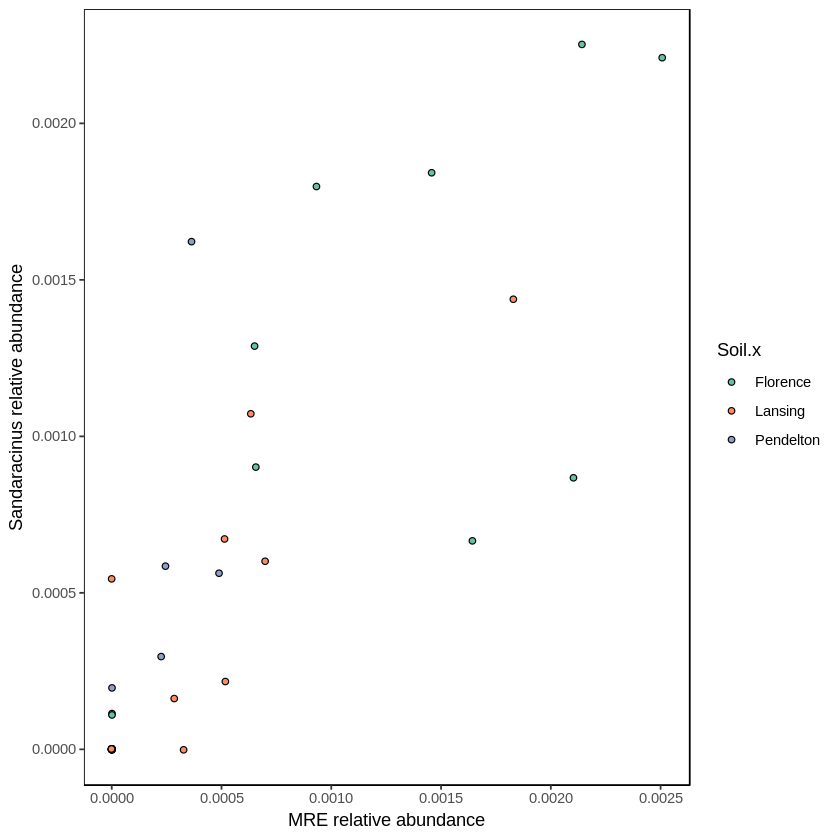

In [359]:
cs = brewer.pal(3,"Set2")
df = full_join(MREtab,Taxtab, by = "sample_Sample") 
p1 = df %>%
    #filter(OTU %in% c("ASV14", "ASV18")) %>%
    ggplot(.,aes(x = sAbund.x, y = sAbund.y, fill = Soil.x, shape = SampleType)) +
        geom_jitter(shape = 21, pch = 2) +
        theme_pub()+
        scale_fill_manual(values = cs) +#, labels = c("Bulk hyphosphere", "Bulk soil"))+
        ylab("Sandaracinus relative abundance") +
        xlab("MRE relative abundance")#+
       # facet_grid(Soil.x~OTU)
p1

outfile = file.path(figDir, 'MRExSandaracinus.pdf')
pdf(outfile, width = 4.5, height = 3)
p1
dev.off()

In [362]:
head(df)

sample_Sample,Soil.x,sAbund.x,Soil.y,SampleType,sAbund.y
GVCLHN1-BH,Pendelton,0.0002264177,Pendelton,BH,0.0002964255
GVCLHN1-BS,Pendelton,0.0000000000,Pendelton,BS,0.0000000000
GVCLHN2-BH,Pendelton,0.0002446450,Pendelton,BH,0.0005854801
GVCLHN2-BS,Pendelton,0.0000000000,Pendelton,BS,0.0001971699
GVCLHN3-BH,Pendelton,0.0003644315,Pendelton,BH,0.0016201908
GVCLHN3-BS,Pendelton,0.0000000000,Pendelton,BS,0.0001153509


In [379]:
tmp = df %>% filter(SampleType == "BH")
m1 = lm(sAbund.y~sAbund.x , data = tmp)
summary(m1)


Call:
lm(formula = sAbund.y ~ sAbund.x, data = tmp)

Residuals:
       Min         1Q     Median         3Q        Max 
-8.430e-04 -3.078e-04 -2.589e-05  3.143e-04  9.744e-04 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) 0.0004230  0.0001851   2.285  0.03465 * 
sAbund.x    0.6111713  0.1585021   3.856  0.00116 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0005182 on 18 degrees of freedom
Multiple R-squared:  0.4524,	Adjusted R-squared:  0.4219 
F-statistic: 14.87 on 1 and 18 DF,  p-value: 0.001158


In [ ]:
m1 = lm(sAbund.y~sAbund.x , data = df)
summary(m1)

In [365]:
DC = read.delim(file = '~/Hyphosphere/Exp11/QuickDirtyDNAconc.txt', header = TRUE)
head(DC)

SampleID,Sample,DNA_conc
1_GVCLHN1-BH,GVCLHN1-BH,16.10
2_GVCLHN1-BS,GVCLHN1-BS,9.71
3_GVCLHN2-BH,GVCLHN2-BH,2.37
4_GVCLHN2-BS,GVCLHN2-BS,2.44
5_GVFLHN1-BH,GVFLHN1-BH,20.30
6_GVFLHN1-BS,GVFLHN1-BS,16.70


In [366]:
df.2 = left_join(df, DC, by = c('sample_Sample' = "Sample"))
head(df.2)

Warning message:
“Column `sample_Sample`/`Sample` joining character vector and factor, coercing into character vector”

sample_Sample,Soil.x,sAbund.x,Soil.y,SampleType,sAbund.y,SampleID,DNA_conc
GVCLHN1-BH,Pendelton,0.0002264177,Pendelton,BH,0.0002964255,1_GVCLHN1-BH,16.100
GVCLHN1-BS,Pendelton,0.0000000000,Pendelton,BS,0.0000000000,2_GVCLHN1-BS,9.710
GVCLHN2-BH,Pendelton,0.0002446450,Pendelton,BH,0.0005854801,3_GVCLHN2-BH,2.370
GVCLHN2-BS,Pendelton,0.0000000000,Pendelton,BS,0.0001971699,4_GVCLHN2-BS,2.440
GVCLHN2-BS,Pendelton,0.0000000000,Pendelton,BS,0.0001971699,191_GVCLHN2-BS,2.440
GVCLHN3-BH,Pendelton,0.0003644315,Pendelton,BH,0.0016201908,97_GVCLHN3-BH,0.248


In [375]:

p1 = df.2 %>%
    ggplot(.,aes(x = DNA_conc, y = sAbund.y, fill = Soil.x)) +
        geom_point(pch = 21) +
        theme_pub()

outfile = file.path(figDir, 'SandaracinusxDNAconc.pdf')
pdf(outfile, width = 4.5, height = 3)
p1
dev.off()

png 
  2

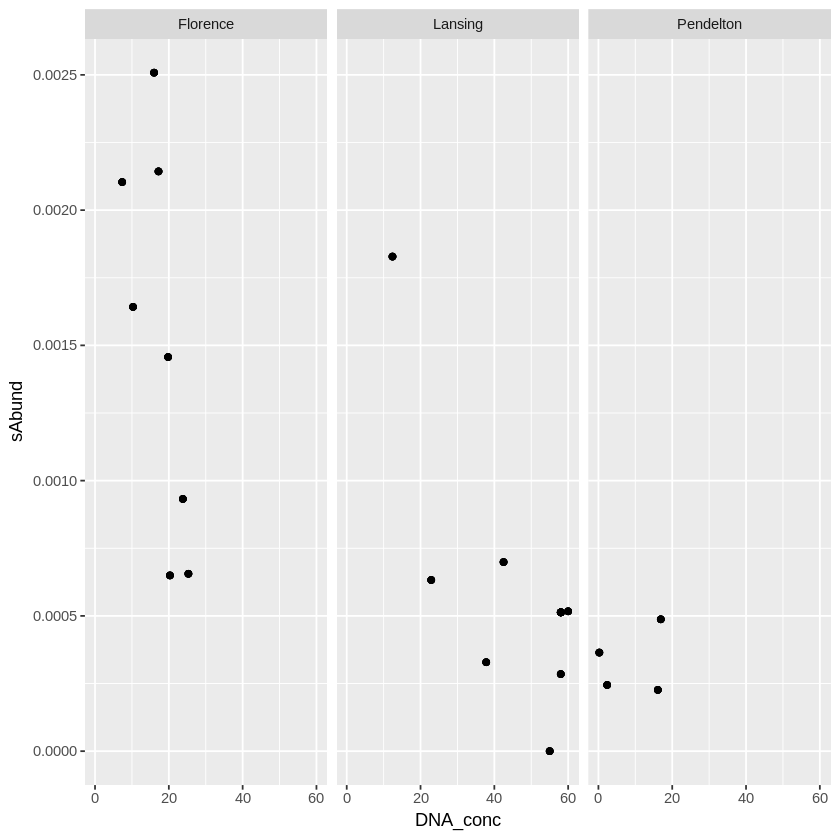

In [184]:
df.2 %>%
    ggplot(.,aes(x = DNA_conc, y = sAbund )) +
        geom_point() +
        facet_wrap(~Soil.x)

In [172]:
tmp = filter(df.2, OTU == "ASV14")
m1 = lm(sAbund~DNA_conc , data = tmp)
summary(m1)


Call:
lm(formula = sAbund ~ DNA_conc, data = tmp)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.051e-03 -3.890e-04  3.127e-05  2.786e-04  1.426e-03 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.333e-03  2.412e-04   5.526 1.75e-05 ***
DNA_conc    -1.565e-05  6.608e-06  -2.368   0.0276 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0006459 on 21 degrees of freedom
Multiple R-squared:  0.2107,	Adjusted R-squared:  0.1732 
F-statistic: 5.607 on 1 and 21 DF,  p-value: 0.02756


In [202]:
df.2 %>% 
    select(sample_Sample, Soil.x, sAbund, Abundance, OTU) %>%
    dcast(., sample_Sample + Soil.x ~ OTU, value.var = "Abundance", fun.aggregate = mean) 

sample_Sample,Soil.x,ASV125,ASV14,ASV18,ASV2257,ASV718
GVCLHN1-BH,Pendelton,0.0000000000,0.0002964255,0.0000000000,0,0
GVCLHN2-BH,Pendelton,0.0000000000,0.0003131638,0.0002723163,0,0
GVCLHN3-BH,Pendelton,0.0000000000,0.0007530464,0.0008671444,0,0
GVCLHN4-BH,Pendelton,0.0000000000,0.0005611535,0.0000000000,0,0
GVFLHN1-BH,Florence,0.0000000000,0.0005837912,0.0007039835,0,0
GVFLHN2-BH,Florence,0.0000000000,0.0011627731,0.0006342399,0,0
GVFLHN3-BH,Florence,0.0000000000,0.0008880995,0.0013638670,0,0
GVFLHN4-BH,Florence,0.0005240015,0.0000000000,0.0008657417,0,0
GVFLHP1-BH,Florence,0.0000000000,0.0007707202,0.0010714890,0,0
GVFLHP2-BH,Florence,0.0000000000,0.0004387141,0.0004630871,0,0


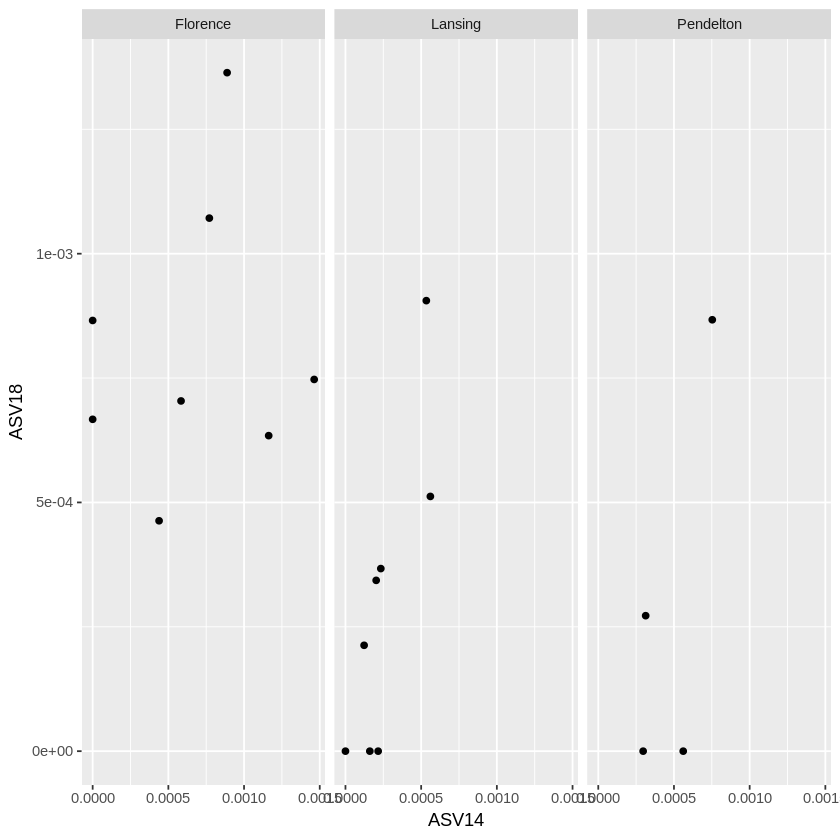

In [204]:
df.2 %>% 
    select(sample_Sample, Soil.x, sAbund, Abundance, OTU) %>%
    dcast(., sample_Sample + Soil.x ~ OTU, value.var = "Abundance", fun.aggregate = mean) %>%
    ggplot(.,aes(x = ASV14, y = ASV18)) +
        geom_point() +
        facet_wrap(~Soil.x)

Warning message:
“Column `sample_Sample`/`Sample` joining factors with different levels, coercing to character vector”

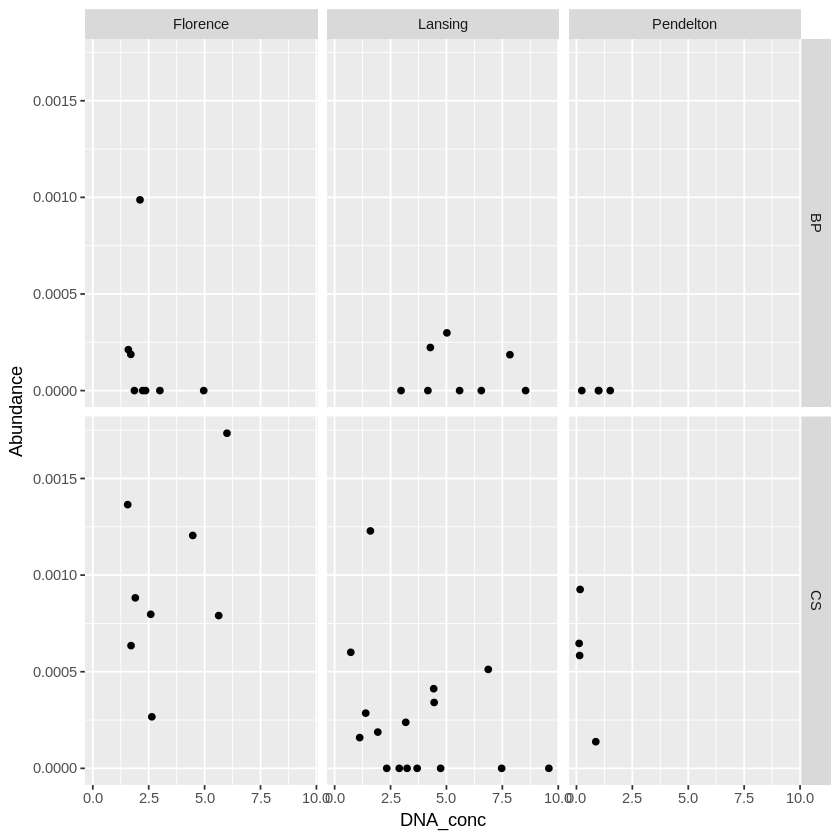

In [209]:
ps.m %>% filter(OTU == "ASV14" & SampleType %in% c("BP", "CS")) %>%
 left_join(., DC, by = c('sample_Sample' = "Sample")) %>%
     ggplot(.,aes(x = DNA_conc, y = Abundance)) +
        geom_point() +
        facet_grid(SampleType~Soil)

In [243]:
# Check ASV 14 in all samples

In [257]:
Taxtab = ps %>% 
transform_sample_counts(., function(x) x/sum(x)) %>% 
                        prune_taxa(c("ASV14","ASV18"),.) %>%
                        psmelt()
                        #prune_taxa(c("ASV17"),.)
head(Taxtab)

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

,OTU,Sample,Abundance,sample_Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul,Kingdom,Phylum,Class,Order,Family
167,ASV14,77_GVN7HN1-RH,0.14877600,GVN7HN1-RH,3,GVN7HN1,Gv,Lansing,RH,HN,NA,27,1,NA,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae
42,ASV14,172_GVN7HN3-RH,0.08153196,GVN7HN3-RH,3,GVN7HN3,Gv,Lansing,RH,HN,NA,27,3,NA,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae
24,ASV14,164_GVFLHN3-RH,0.07741132,GVFLHN3-RH,3,GVFLHN3,Gv,Florence,RH,HN,NA,27,3,NA,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae
171,ASV14,79_GVN7HN2-RH,0.07004182,GVN7HN2-RH,3,GVN7HN2,Gv,Lansing,RH,HN,NA,27,2,NA,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae
153,ASV14,70_GVFLHN2-CH,0.06077249,GVFLHN2-CH,3,GVFLHN2,Gv,Florence,CH,HN,NA,27,2,NA,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae
154,ASV14,65_GVCLHN2-RH,0.06073228,GVCLHN2-RH,3,GVCLHN2,Gv,Pendelton,RH,HN,NA,27,2,NA,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae


In [258]:
df.2 = left_join(Taxtab, DC, by = c('sample_Sample' = "Sample"))
df.2 %>% filter(sample_Sample == "GVFLHP1-CH")

Warning message:
“Column `sample_Sample`/`Sample` joining factors with different levels, coercing to character vector”

OTU,Sample,Abundance,sample_Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,⋯,DAI,Rep,Concentration_ng.ul,Kingdom,Phylum,Class,Order,Family,SampleID,DNA_conc
ASV14,73_GVFLHP1-CH,0.01792885,GVFLHP1-CH,3,GVFLHP1,Gv,Florence,CH,HP,⋯,27,1,NA,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,73_GVFLHP1-CH,0.875
ASV18,73_GVFLHP1-CH,0.00905394,GVFLHP1-CH,3,GVFLHP1,Gv,Florence,CH,HP,⋯,27,1,NA,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,73_GVFLHP1-CH,0.875


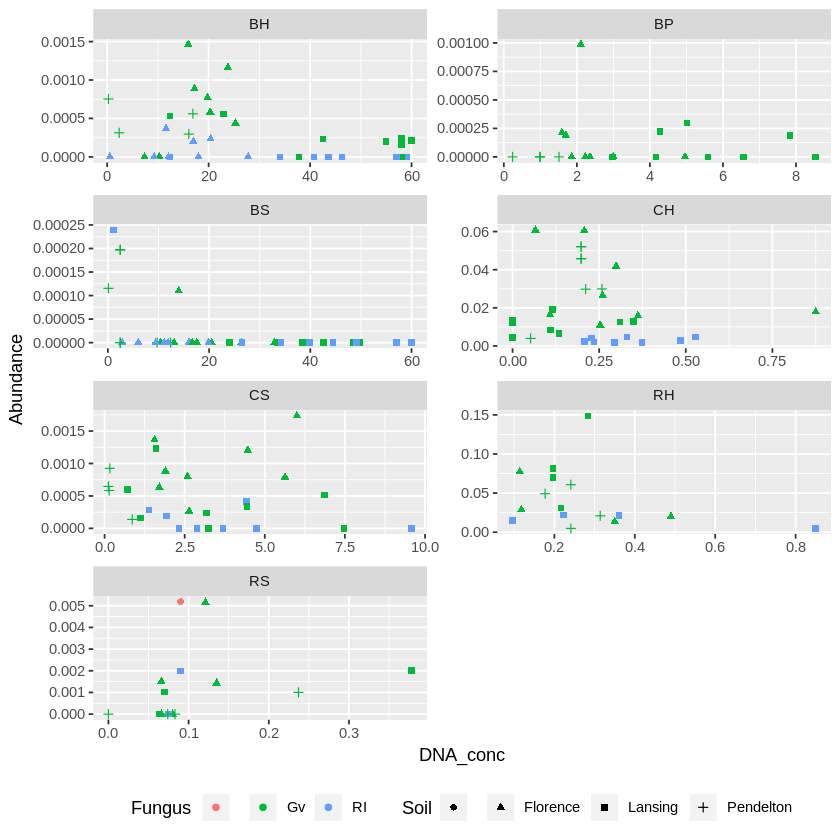

In [260]:
df.2 %>% 
    filter(OTU == "ASV14" & SampleType %in% c("BP", "BH", "CS", "RH", "RS", "CH", "BS")) %>%
    ggplot(., aes(x = DNA_conc, y = Abundance)) +
        geom_point(aes(color = Fungus, shape = Soil))+
        facet_wrap(~SampleType, scales = "free", ncol = 2) +
        theme(legend.position = "bottom") #+
        #scale_y_continuous(trans = "log2")

In [266]:
tmp = ps %>% 
    subset_samples(Sample == "GVFLHP1-CH") %>%
    transform_sample_counts(., function(x) x/sum(x)) %>% 
    psmelt() %>% 
    arrange(desc(Abundance)) %>% select(Abundance, OTU, Phylum, Class, Order, Family)
tmp[1:100,]

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

Abundance,OTU,Phylum,Class,Order,Family
0.063352004,ASV577,Chloroflexi,Chloroflexia,Kallotenuales,NA
0.049643213,ASV312,Chloroflexi,Chloroflexia,Kallotenuales,NA
0.040026599,ASV118,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae
0.037801478,ASV143,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae
0.032507225,ASV1002,Chloroflexi,Chloroflexia,Kallotenuales,AKIW781
0.018875163,ASV57,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae
0.017928847,ASV14,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae
0.016650042,ASV288,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae
0.015064324,ASV23,Fibrobacteres,Fibrobacteria,Fibrobacterales,Fibrobacteraceae
0.009616614,ASV3476,Chloroflexi,Chloroflexia,Kallotenuales,NA


In [271]:
tmp %>% group_by(Family) %>% summarise(sAbund = sum(Abundance)) %>% arrange(desc(sAbund))

Family,sAbund
NA,0.235351288
Burkholderiaceae,0.157497634
Sandaracinaceae,0.039873143
AKIW781,0.036522673
Xanthobacteraceae,0.031074964
A4b,0.028056984
Roseiflexaceae,0.023453285
Fibrobacteraceae,0.022430241
Microscillaceae,0.021330469
Unknown_Family,0.020614338


# Save deseqtable

In [289]:
write.table(df.l2fc.CHCS, file = '~/Hyphosphere/Exp11/df_l2fc_CHCS_bothtreatments.txt', sep = '\t')